# Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

## Problem Details

In [2]:
## TODO: აქ ჩამოვწერთ, რასაც გადავწყვეტთ რომ უნდა გადავჭრათ

## Steps:
### 1. Exploring Data

### 1. Data analysis

First, Let's find out what our data actually contains.

In [3]:
data = pd.read_csv("Local/mfp-diaries.tsv", sep='\t', header=None, names=["user_id", "diary_date", "food_list", "daily_intake_and_goal"])

Number of its' features and variables

In [4]:
data.shape

(587187, 4)

Quickly checking if there are some duplicated rows in our data, because we don't need excessive information

In [5]:
print(f"Duplicated rows: {data.duplicated().sum()}")

Duplicated rows: 0


Good, there was none.
Now we need to check if there are any missing values in our data. Because later on it may cause problems (For example, if we decide to use K-means clustering; it can't handle missing values).

In [6]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
user_id                  0
diary_date               0
food_list                0
daily_intake_and_goal    0
dtype: int64


Fortunatelly, neither missing values are in our data.

Sample row for convenience

In [7]:
user_id = data.iloc[1006,0]
date = data.iloc[1006,1]
food_entries = json.loads(data.iloc[1006, 2])
agregate_intake_goal = json.loads(data.iloc[1006,3])
print(food_entries)

[{'meal': 'Breakfast', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '100'}, {'name': 'Carbs', 'value': '11'}, {'name': 'Fat', 'value': '0'}, {'name': 'Protein', 'value': '13'}, {'name': 'Sodium', 'value': '55'}, {'name': 'Sugar', 'value': '7'}], 'name': 'Yoplait - Greek 100 Calories Vanilla, 150 g'}], 'sequence': 1}, {'meal': 'Lunch', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '360'}, {'name': 'Carbs', 'value': '30'}, {'name': 'Fat', 'value': '18'}, {'name': 'Protein', 'value': '15'}, {'name': 'Sodium', 'value': '690'}, {'name': 'Sugar', 'value': '3'}], 'name': 'Alexia - Mozzarella Stix, 6 stix'}, {'nutritions': [{'name': 'Calories', 'value': '17'}, {'name': 'Carbs', 'value': '0'}, {'name': 'Fat', 'value': '0'}, {'name': 'Protein', 'value': '4'}, {'name': 'Sodium', 'value': '55'}, {'name': 'Sugar', 'value': '0'}], 'name': 'Home Cooked - 2 Hard Boiled Egg Whites, 1 hard boiled eggs'}], 'sequence': 2}, {'meal': 'Snacks', 'dishes': [{'nutritions': [{'name': 'Calo

Data parsing

In [8]:
monthly = {}

def init_nutrients(month):
    month["calories"] = {}
    # np.empty(month["month_length"]);
    # month["carbs"] = []
    # month["fat"] = []
    # month["protein"] = []
    # month["sodium"] = []
    # month["sugar"] = []
    month["goal_calories"] = {}
    # month["goal_carbs"] = []
    # month["goal_fat"] = []
    # month["goal_protein"] = []

def add_nutrients(month, agregate_intake_goal, date):
    change = 0

    for i in range(len(agregate_intake_goal["total"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            month["calories"][date] = agregate_intake_goal["total"][i]["value"]
            change += 1
    for i in range(len(agregate_intake_goal["goal"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            month["goal_calories"][date] = agregate_intake_goal["goal"][i]["value"]
            change += 1

    if change != 2:
        print(agregate_intake_goal)

def getMonthLength(month, year):
    if month == 2:
        if year % 4 == 0:
            return 29
        else: return 28
    if month <= 7:
        if month % 2 == 0:
            return 30
        else: return 31
    else:
        if month % 2 == 0:
            return 31
        else: return 30 

for i in range(int(len(data) / 100)):
    # read i-th row
    user_id = data.iloc[i,0]
    date = data.iloc[i,1]
    food_entries = json.loads(data.iloc[i, 2])
    agregate_intake_goal = json.loads(data.iloc[i,3])

    if user_id not in monthly:
        monthly[user_id] = {}

    month = date[5:7] + "/" + date[0:4]
    if month not in monthly[user_id]:
        monthly[user_id][month] = {}
        monthly[user_id][month]["month_length"] = getMonthLength(int(date[5:7]), int(date[0:4]))
        monthly[user_id][month]["days"] = 0
        monthly[user_id][month]["food"] = {}
        monthly[user_id][month]["food_count"] = 0
        init_nutrients(monthly[user_id][month])
    monthly[user_id][month]["days"] += 1
    add_nutrients(monthly[user_id][month], agregate_intake_goal, int(date[8:]))
    for meal in food_entries:
        for dish in meal["dishes"]:
            food_name = dish["name"][0:dish["name"].index(',')]
            if food_name != "Quick Added Calories":
                if food_name not in monthly[user_id][month]["food"]:
                    monthly[user_id][month]["food"][food_name] = 0    
                monthly[user_id][month]["food"][food_name] += 1
                monthly[user_id][month]["food_count"] += 1

Data visualization

Active days: 27


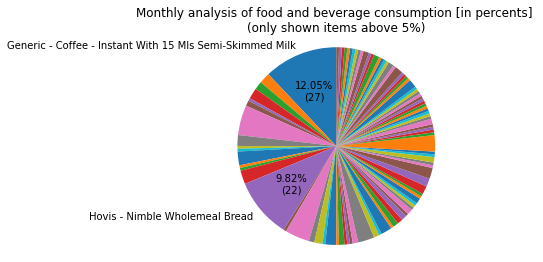

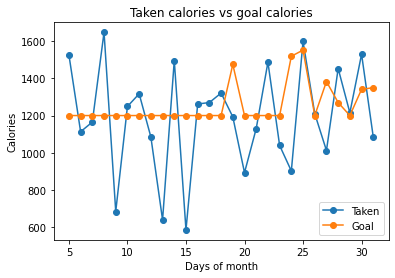

In [11]:
sample_month = monthly[12]["01/2015"]
food = sample_month["food"]

def filter_value(val):
    if (val < 5):
        return ""
    return '{:.2f}%\n({:.0f})'.format(val, sample_month["food_count"] * val / 100)

labels = []
for key in food.keys():
    if food[key] / sample_month["food_count"] < 0.07:
        labels.append("")
    else:
        labels.append(key)

magnitudes = food.values()

fig1, ax1 = plt.subplots()
ax1.pie(magnitudes, labels=labels, autopct=filter_value, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Monthly analysis of food and beverage consumption [in percents] \n(only shown items above 5%)")

print("Active days:", sample_month["days"])
plt.show()

plt.plot([key for key in sample_month["calories"].keys()], [value for value in sample_month["calories"].values()], marker='o')
plt.plot([key for key in sample_month["goal_calories"].keys()], [value for value in sample_month["goal_calories"].values()], marker='o')
plt.title("Taken calories vs goal calories");
plt.xlabel("Days of month")
plt.ylabel("Calories")
plt.legend(["Taken", "Goal"])
plt.show()